In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import operator
from pyomo import environ as pe
import os
import pandas as pd

In [2]:
df=pd.DataFrame()
N = 20
df['x'] = [random.random() for i in range(N)]
df['y'] = [random.random() for i in range(N)]

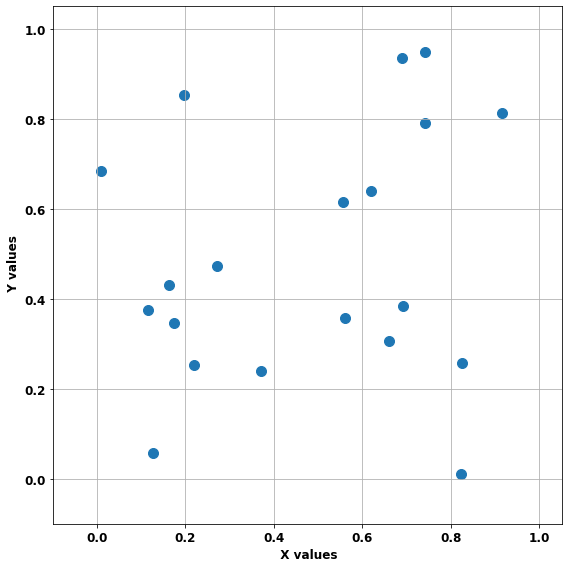

In [3]:

plt.figure(figsize=(8,8))
plt.scatter(df['x'], df['y'], s= 100)
plt.xlim(-0.1,1.05)
plt.ylim(-0.1,1.05)
plt.xlabel('  X values ', fontsize=12, fontweight='bold')
plt.ylabel('  Y values ', fontsize=12, fontweight='bold')
plt.xticks( fontsize=12, fontweight='bold')
plt.yticks( fontsize=12, fontweight='bold')
plt.grid()
plt.tight_layout()

plt.savefig('Dots '+  '.jpg', format='jpg', dpi=400)


In [ ]:
BM= 4
K= 3
M = 3
plt.figure(figsize=(8,8))
counter =0 
for M in [3]:
    for K in [3]:
        counter +=1
        model = AbstractModel()
        model.i = RangeSet(N)
        model.m = RangeSet(M)
        model.k = RangeSet(K) # number of lines 
        model.target = Param(model.i, initialize=0, mutable=True)
        model.r = Var(model.i,bounds=(0, 1000) , within = Reals)
        model.c = Var(model.k, model.m, bounds=(-100, 100) , within = Reals)
        model.U = Var(model.i, model.k,bounds=(0, 1) , within = Binary)
        def rule_C1(model,i,k):
            return sum(model.c[k,m]*df.loc[i-1,'x']**(m-1) for m in model.m ) - df.loc[i-1,'y'] <= model.r[i] + BM*(1-model.U[i,k])
        model.C1 = Constraint(model.i, model.k, rule=rule_C1)
        def rule_C2(model,i,k):
            return sum(model.c[k,m]*df.loc[i-1,'x']**(m-1) for m in model.m ) - df.loc[i-1,'y'] >= -model.r[i] - BM*(1-model.U[i,k])
        model.C2 = Constraint(model.i,model.k,  rule=rule_C2)
        def rule_C3(model,i):
            return sum(model.U[i,k] for k in model.k) == 1
        model.C3 = Constraint(model.i,  rule=rule_C3)
        def rule_C4(model,k):
            if k>1:
                return sum(model.U[i,k-1] for i in model.i) <= sum(model.U[i,k] for i in model.i)
            else:
                return Constraint.Skip
        model.C4 = Constraint(model.k,  rule=rule_C4)
        
        def rule_C5(model,k):
            return sum(model.U[i,k] for i in model.i) >= 1
        model.C5 = Constraint(model.k,  rule=rule_C5)
        
        def rule_of(model):
            return sum(model.r[i] for i in model.i)
        model.obj = Objective(rule=rule_of, sense=minimize)

        instance = model.create_instance()
        #solver_manager = pe.SolverManagerFactory('neos')
        #results = solver_manager.solve(instance, solver='cplex', options={'mipgap':0.5})
        
        opt = SolverFactory('cbc')
        opt.options = {'sec': 360, 'threads': 2, 'ratio': 0.5}
        results = opt.solve(instance)


        print('OF= ',value(instance.obj))
        plt.scatter(df['x'], df['y'], s= 100)

        for k in instance.k:
            X=np.linspace(0,1,100)
            Y = [sum(value(instance.c[k,m])*x**(m-1) for m in instance.m ) for x in X ]
            plt.plot(X,Y)
            xdata = [df.loc[i-1,'x'] for i in instance.i if value(instance.U[i,k])>0]
            ydata = [df.loc[i-1,'y'] for i in instance.i if value(instance.U[i,k])>0]
            plt.scatter(xdata,ydata, s= 100, zorder =2)


        plt.xlim(-0.1,1.05)
        plt.ylim(-0.1,1.05)
        plt.xlabel('  X values ', fontsize=12, fontweight='bold')
        plt.ylabel('  Y values ', fontsize=12, fontweight='bold')
        plt.xticks( fontsize=12, fontweight='bold')
        plt.yticks( fontsize=12, fontweight='bold')
        plt.grid()
        plt.tight_layout()
        plt.savefig('Multi-line ' + str(K+(M-1)*3)+  '.jpg', format='jpg', dpi=400)
        

plt.savefig('Multi-line '+  '.jpg', format='jpg', dpi=400)

